# Предсказание данных **MNIST**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
import struct
from array import array

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from autoencoders.autoencoder import Autoencoder
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [2]:
class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_path, labels_path):
        with open(labels_path, 'rb') as label_file:
            magic, size = struct.unpack(">II", label_file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch in labels. Got {magic}, expected 2049')
            labels = array("B", label_file.read())

        with open(images_path, 'rb') as image_file:
            magic, size, rows, cols = struct.unpack(">IIII", image_file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch in images. Got {magic}, expected 2051')
            image_data = array("B", image_file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(rows, cols)
            images.append(img)

        return np.array(images), np.array(labels)

    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        X_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (X_train, y_train), (X_test, y_test)


training_images_filepath = '../data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = '../data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = '../data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = '../data/mnist-dataset/t10k-labels.idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                   test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

X_train = np.array([np.ravel(x) for x in X_train], dtype=np.float32) / 255.0
X_test = np.array([np.ravel(x) for x in X_test], dtype=np.float32) / 255.0

X_train_val, X_test = X_train, X_test
y_train_val, y_test = y_train, y_test

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

### Обучение автокодировщика

In [3]:
input_size = X_train.shape[1]  

autoencoder = Autoencoder(input_dim=input_size, latent_dim=128)
trainer = pl.Trainer(max_epochs=50, accelerator="auto")
trainer.fit(autoencoder, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 566 K  | train
1 | decoder | Sequential | 566 K  | train
2 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.532     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 750/750 [00:12<00:00, 62.26it/s, v_num=12]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 750/750 [00:12<00:00, 62.03it/s, v_num=12]


### Визуализируем исходные и восстановленные изображения

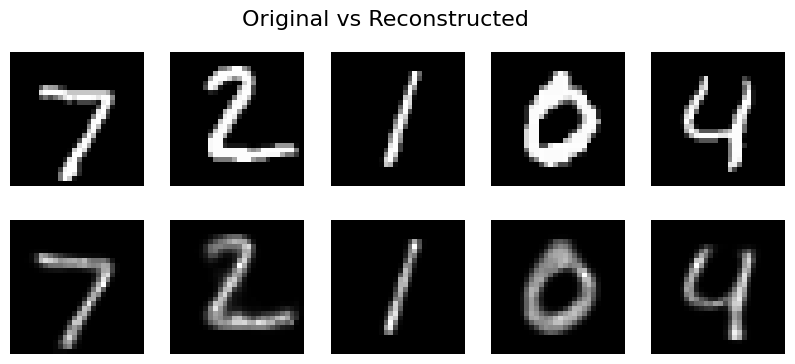

In [4]:
# TODO: поэксперементировать с кол-вом эпох, latent_dim, Dropout

def plot_reconstructions(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for x_batch, _ in data_loader:
            x_batch = x_batch[:num_images]
            x_recon = model(x_batch)
            break

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(x_batch[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(x_recon[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Original vs Reconstructed", fontsize=16)
    plt.show()

plot_reconstructions(autoencoder, test_loader)

### Выводим оценку точности предсказаний

In [33]:
from sklearn.metrics import mean_squared_error

autoencoder.eval()
all_originals = []
all_recons = []

with torch.no_grad():
    for x_batch, _ in test_loader:
        x_flat = x_batch.view(x_batch.shape[0], -1)
        recons = autoencoder(x_flat)
        all_originals.append(x_flat.numpy())
        all_recons.append(recons.numpy())

all_originals = np.concatenate(all_originals)
all_recons = np.concatenate(all_recons)

mse = mean_squared_error(all_originals, all_recons)
print(f"Reconstruction MSE on test set: {mse:.6f}")

Reconstruction MSE on test set: 0.000000


### Получение латентных представлений

In [5]:
def extract_latent_representations(model, data_loader):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            z = model.get_latent(x_batch)
            latents.append(z.numpy())
            labels.append(y_batch.numpy())

    return np.concatenate(latents), np.concatenate(labels)

X_train_latent, y_train_labels = extract_latent_representations(autoencoder, train_loader)
X_test_latent, y_test_labels = extract_latent_representations(autoencoder, test_loader)

### Обучение модели

In [6]:
output_size = len(np.unique(y_train))

model = NeuralNetworkPL(
    input_size=input_size,
    hidden_sizes=[100, 200],
    output_size=output_size,
    activation='relu',
    task='classification'
)

trainer = pl.Trainer(max_epochs=50, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 100 K  | train
--------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 750/750 [00:05<00:00, 135.30it/s, v_num=13]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 750/750 [00:05<00:00, 135.11it/s, v_num=13]


### Тестирование

In [7]:
trainer.test(model, dataloaders=test_loader)\
    
def predict(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            all_preds.append(probs.numpy())
    return np.concatenate(all_preds)

y_pred_probs = predict(model, test_loader)

Testing DataLoader 0:   0%|          | 0/157 [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 269.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.18241514265537262    │
└───────────────────────────┴───────────────────────────┘

### Визуализация

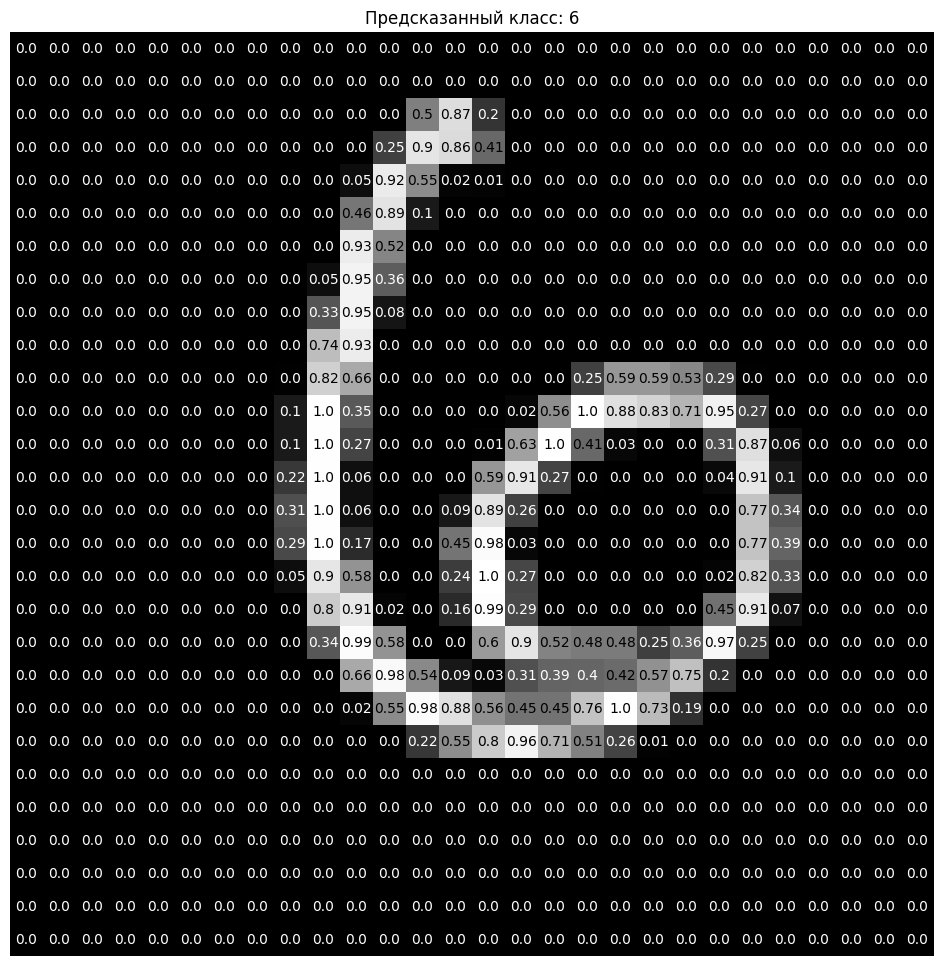

In [8]:
def visualize_input(img, ax):
    img_reshaped = img.reshape(28, 28)
    ax.imshow(img_reshaped, cmap='gray')
    width, height = img_reshaped.shape
    thresh = img_reshaped.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img_reshaped[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img_reshaped[x][y] < thresh else 'black')

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_test[100], ax)
plt.title(f"Предсказанный класс: {np.argmax(y_pred_probs[100])}")
plt.axis('off')
plt.show()

### Сдвиг к другому классу

In [24]:
# X_train_latent.shape = [n_samples, latent_dim]
# y_train_labels.shape = [n_samples]

class_means = {}
for label in np.unique(y_train_labels):
    mask = (y_train_labels == label)
    class_means[label] = np.mean(X_train_latent[mask], axis=0)

In [25]:
index = 200  # индекс изображения в тестовой выборке
original_image = X_test[index]
original_label = y_test_labels[index]

print(f"Оригинальный класс: {original_label}")

Оригинальный класс: 3


In [26]:
x_tensor = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0) 
z = autoencoder.get_latent(x_tensor).detach().numpy()

In [ ]:
target_class = 8  # например, хотим превратить цифру в "8"
delta_z = class_means[target_class] - class_means[original_label]  # направление сдвига
z_shifted = z + 0.5 * delta_z  # коэффициент регулирует силу сдвига

In [28]:
z_shifted_tensor = torch.tensor(z_shifted, dtype=torch.float32)
x_reconstructed = autoencoder.decoder(z_shifted_tensor).detach().numpy()

# Обрезаем значения в диапазон [0, 1]
x_reconstructed = np.clip(x_reconstructed, 0, 1)

In [29]:
x_recon_tensor = torch.tensor(x_reconstructed, dtype=torch.float32)
logits = model(x_recon_tensor)
probs = torch.softmax(logits, dim=1).detach().numpy()

predicted_class = np.argmax(probs)

print(f"Предсказанный класс после сдвига: {predicted_class}")
print(f"Вероятности: {probs[0]}")

Предсказанный класс после сдвига: 5
Вероятности: [4.2580818e-06 8.6278480e-04 3.7993964e-08 2.0282878e-06 1.7423377e-10
 9.9913043e-01 1.3845049e-10 5.1194610e-07 1.5538998e-10 6.6487904e-09]


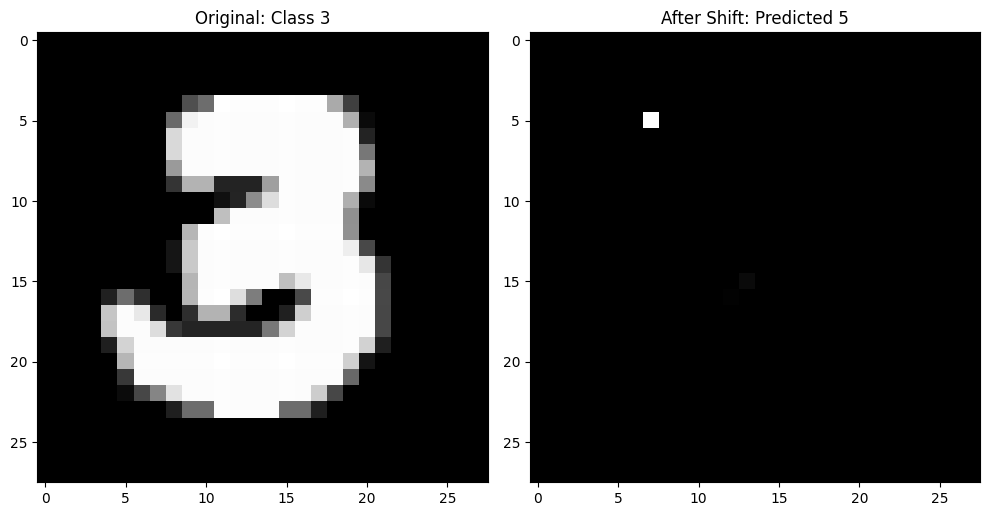

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Оригинал
axes[0].imshow(original_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Original: Class {original_label}")

# После сдвига
axes[1].imshow(x_reconstructed.reshape(28, 28), cmap='gray')
axes[1].set_title(f"After Shift: Predicted {predicted_class}")

plt.tight_layout()
plt.show()